In [1]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install numpy

In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from google.colab.patches import cv2_imshow # For displaying images in Colab
from google.colab import drive

print("Basic libraries for image processing imported successfully!")

Basic libraries for image processing imported successfully!


In [3]:
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


In [4]:
dataset_root = '/content/drive/MyDrive/Data/Final hands'
proper_train_path = os.path.join(dataset_root, 'Proper', 'train')
proper_val_path = os.path.join(dataset_root, 'Proper', 'valid')
improper_train_path = os.path.join(dataset_root, 'Improper', 'train')
improper_val_path = os.path.join(dataset_root, 'Improper', 'valid')

# Define paths for annotation files
train_annotation_path_proper = os.path.join(dataset_root, 'Proper', 'train', '_annotations.coco.json')
train_annotation_path_improper = os.path.join(dataset_root, 'Improper', 'train', '_annotations.coco.json')
val_annotation_path_proper = os.path.join(dataset_root, 'Proper', 'valid', '_annotations.coco.json')
val_annotation_path_improper = os.path.join(dataset_root, 'Improper', 'valid', '_annotations.coco.json')

print(f"Dataset root directory: {dataset_root}")
print(f"Proper training images in: {proper_train_path}")
print(f"Proper validation images in: {proper_val_path}")
print(f"Improper training images in: {improper_train_path}")
print(f"Improper validation images in: {improper_val_path}")
print(f"Proper training annotations: {train_annotation_path_proper}")
print(f"Improper training annotations: {train_annotation_path_improper}")
print(f"Proper validation annotations: {val_annotation_path_proper}")
print(f"Improper validation annotations: {val_annotation_path_improper}")

Dataset root directory: /content/drive/MyDrive/Data/Final hands
Proper training images in: /content/drive/MyDrive/Data/Final hands/Proper/train
Proper validation images in: /content/drive/MyDrive/Data/Final hands/Proper/valid
Improper training images in: /content/drive/MyDrive/Data/Final hands/Improper/train
Improper validation images in: /content/drive/MyDrive/Data/Final hands/Improper/valid
Proper training annotations: /content/drive/MyDrive/Data/Final hands/Proper/train/_annotations.coco.json
Improper training annotations: /content/drive/MyDrive/Data/Final hands/Improper/train/_annotations.coco.json
Proper validation annotations: /content/drive/MyDrive/Data/Final hands/Proper/valid/_annotations.coco.json
Improper validation annotations: /content/drive/MyDrive/Data/Final hands/Improper/valid/_annotations.coco.json


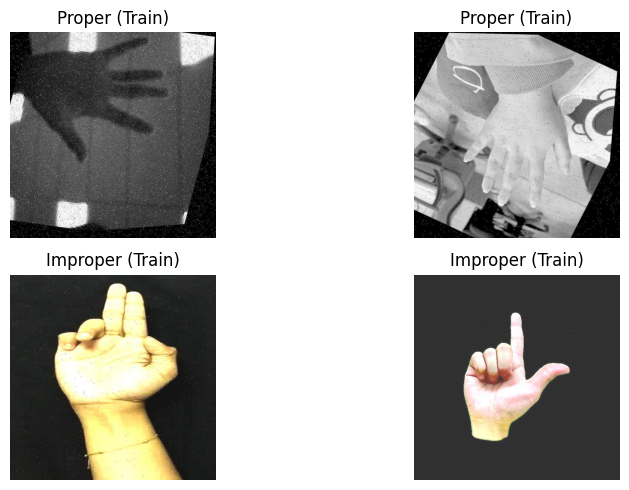

In [6]:
def load_image(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

proper_train_images = [os.path.join(proper_train_path, f) for f in os.listdir(proper_train_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))] if os.path.exists(proper_train_path) else []
improper_train_images = [os.path.join(improper_train_path, f) for f in os.listdir(improper_train_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))] if os.path.exists(improper_train_path) else []

num_samples = 2
plt.figure(figsize=(10, 5)) # Adjusted figure size

if proper_train_images:
    for i in range(min(num_samples, len(proper_train_images))):
        plt.subplot(2, num_samples, i + 1)
        random_proper = random.choice(proper_train_images)
        img = load_image(random_proper)
        if img is not None:
            plt.imshow(img)
            plt.title("Proper (Train)")
            plt.axis('off')
        else:
            print(f"Could not load: {random_proper}")
else:
    print("No proper hand posture images found in the training folder.")

if improper_train_images:
    for i in range(min(num_samples, len(improper_train_images))):
        plt.subplot(2, num_samples, i + num_samples + 1)
        random_improper = random.choice(improper_train_images)
        img = load_image(random_improper)
        if img is not None:
            plt.imshow(img)
            plt.title("Improper (Train)")
            plt.axis('off')
        else:
            print(f"Could not load: {random_improper}")
else:
    print("No improper hand posture images found in the training folder.")

plt.tight_layout()
plt.show()

In [7]:
def extract_hand_keypoints_from_coco(json_path, image_filename):
    """
    Extracts hand keypoints from a COCO annotation file for a specific image.

    Args:
        json_path (str): Path to the COCO annotation JSON file.
        image_filename (str): Filename of the image to find annotations for.

    Returns:
        list or None: A list of flattened keypoint coordinates [x1, y1, x2, y2, ...]
                      or None if no hand keypoints are found or an error occurs.
                      Assumes keypoint format is [x, y, visibility]. This function
                      extracts only x and y, and flattens them.
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
            keypoints_list = []
            image_id = None

            for img in data.get('images', []):
                if img.get('file_name') == image_filename:
                    image_id = img.get('id')
                    break

            if image_id is not None:
                for annotation in data.get('annotations', []):
                    if annotation.get('image_id') == image_id and 'keypoints' in annotation and len(annotation['keypoints']) > 0:

                        kps = annotation['keypoints']

                        flattened_kps = [kps[i] for i in range(0, len(kps), 3)] + [kps[i] for i in range(1, len(kps), 3)]
                        keypoints_list.append(flattened_kps)


            return keypoints_list if keypoints_list else None

    except Exception as e:
        print(f"Error reading or parsing JSON: {json_path} - {e}")
        return None

In [8]:
def get_images(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

def process_images_for_keypoints(image_paths, annotation_path, feature_list, category_name):
    print(f"\nExtracting keypoints for {category_name} images from {annotation_path}")
    if not os.path.exists(annotation_path):
        print(f"Annotation file not found: {annotation_path}")
        return

    for img_file in image_paths:

        image_filename = os.path.basename(img_file)
        keypoints = extract_hand_keypoints_from_coco(annotation_path, image_filename)

        if keypoints is not None and len(keypoints) > 0:


            feature_list.append(keypoints[0])
        else:


            pass

In [9]:
def random_horizontal_flip_keypoints(keypoints, image_width):
    """
    Applies random horizontal flip to keypoints.

    Args:
        keypoints (list): A list of flattened keypoint coordinates [x1, y1, x2, y2, ...].
        image_width (int): The width of the image.

    Returns:
        list: Flipped keypoint coordinates.
    """
    if keypoints is None:
        return None

    flipped_keypoints = []


    num_kps = len(keypoints) // 2
    for i in range(num_kps):

        flipped_x = image_width - keypoints[i]
        flipped_keypoints.append(flipped_x)

    for i in range(num_kps):
        flipped_keypoints.append(keypoints[num_kps + i])

    return flipped_keypoints

def random_scale_keypoints(keypoints, scale_range=(0.8, 1.2)):
    """
    Applies random scaling to keypoints relative to a central point (e.g., bounding box center).
    Note: This requires knowledge of the original image dimensions and potentially the bounding box.
    For simplicity here, we'll scale relative to the average keypoint position.
    A more robust implementation would use image dimensions and bounding boxes.

    Args:
        keypoints (list): A list of flattened keypoint coordinates [x1, y1, x2, y2, ...].
        scale_range (tuple): Minimum and maximum scaling factors.

    Returns:
        list: Scaled keypoint coordinates.
    """
    if keypoints is None:
        return None

    scale_factor = random.uniform(scale_range[0], scale_range[1])
    scaled_keypoints = []


    if len(keypoints) > 0:
        center_x = sum(keypoints[:len(keypoints)//2]) / (len(keypoints)//2) if len(keypoints)//2 > 0 else 0
        center_y = sum(keypoints[len(keypoints)//2:]) / (len(keypoints)//2) if len(keypoints)//2 > 0 else 0
    else:
        center_x, center_y = 0, 0

    num_kps = len(keypoints) // 2
    for i in range(num_kps):

        scaled_x = center_x + (keypoints[i] - center_x) * scale_factor
        scaled_y = center_y + (keypoints[num_kps + i] - center_y) * scale_factor
        scaled_keypoints.append(scaled_x)
    for i in range(num_kps):

         scaled_keypoints.append(scaled_y)


    return scaled_keypoints

def random_translate_keypoints(keypoints, translate_range=(-10, 10)):
    """
    Applies random translation to keypoints.

    Args:
        keypoints (list): A list of flattened keypoint coordinates [x1, y1, x2, y2, ...].
        translate_range (tuple): Minimum and maximum translation values for x and y.

    Returns:
        list: Translated keypoint coordinates.
    """
    if keypoints is None:
        return None

    tx = random.uniform(translate_range[0], translate_range[1])
    ty = random.uniform(translate_range[0], translate_range[1])

    translated_keypoints = []
    num_kps = len(keypoints) // 2
    for i in range(num_kps):
        translated_x = keypoints[i] + tx
        translated_keypoints.append(translated_x)
    for i in range(num_kps):
         translated_y = keypoints[num_kps + i] + ty
         translated_keypoints.append(translated_y)

    return translated_keypoints


def augment_keypoints(keypoints, image_width, image_height, flip_prob=0.5, scale_prob=0.5, translate_prob=0.5):
    """
    Applies random data augmentation to keypoints.

    Args:
        keypoints (list): A list of flattened keypoint coordinates [x1, y1, x2, y2, ...].
        image_width (int): The width of the image.
        image_height (int): The height of the image.
        flip_prob (float): Probability of applying horizontal flip.
        scale_prob (float): Probability of applying scaling.
        translate_prob (float): Probability of applying translation.

    Returns:
        list: Augmented keypoint coordinates.
    """
    if keypoints is None:
        return None

    augmented_kps = list(keypoints)

    if random.random() < flip_prob:
        augmented_kps = random_horizontal_flip_keypoints(augmented_kps, image_width)

    if random.random() < scale_prob:
        augmented_kps = random_scale_keypoints(augmented_kps)

    if random.random() < translate_prob:
        augmented_kps = random_translate_keypoints(augmented_kps)

    return augmented_kps

def load_and_preprocess_data_with_augmentation(proper_paths, improper_paths, proper_annotation_path, improper_annotation_path, augment=True):
    """
    Loads images and extracts keypoints, applies data augmentation, and prepares data for the model.

    Args:
        proper_paths (list): List of file paths for proper hand posture images.
        improper_paths (list): List of file paths for improper hand posture images.
        proper_annotation_path (str): Path to the proper hand posture COCO annotation file.
        improper_annotation_path (str): Path to the improper hand posture COCO annotation file.
        augment (bool): Whether to apply data augmentation.

    Returns:
        tuple: (features, labels) - numpy arrays of keypoint features and labels.
               Returns None, None if no data is found.
    """
    all_features = []
    all_labels = []

    # Process Proper hands
    for img_path in proper_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue
        h, w, _ = img.shape
        img_filename = os.path.basename(img_path)
        keypoints_list = extract_hand_keypoints_from_coco(proper_annotation_path, img_filename)

        if keypoints_list:
            for kps in keypoints_list:
                all_features.append(kps)
                all_labels.append(0)

                if augment:

                    augmented_kps_flipped = augment_keypoints(list(kps), w, h, flip_prob=1.0, scale_prob=0.0, translate_prob=0.0) # Ensure flip is attempted
                    if augmented_kps_flipped:
                         all_features.append(augmented_kps_flipped)
                         all_labels.append(0)

                    augmented_kps_scaled = augment_keypoints(list(kps), w, h, flip_prob=0.0, scale_prob=1.0, translate_prob=0.0) # Ensure scale is attempted
                    if augmented_kps_scaled:
                         all_features.append(augmented_kps_scaled)
                         all_labels.append(0)

                    augmented_kps_translated = augment_keypoints(list(kps), w, h, flip_prob=0.0, scale_prob=0.0, translate_prob=1.0) # Ensure translate is attempted
                    if augmented_kps_translated:
                         all_features.append(augmented_kps_translated)
                         all_labels.append(0)


    # Process Improper hands
    for img_path in improper_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue
        h, w, _ = img.shape
        img_filename = os.path.basename(img_path)
        keypoints_list = extract_hand_keypoints_from_coco(improper_annotation_path, img_filename)

        if keypoints_list:
            for kps in keypoints_list:
                all_features.append(kps)
                all_labels.append(1)

                if augment:

                    augmented_kps_flipped = augment_keypoints(list(kps), w, h, flip_prob=1.0, scale_prob=0.0, translate_prob=0.0) # Ensure flip is attempted
                    if augmented_kps_flipped:
                         all_features.append(augmented_kps_flipped)
                         all_labels.append(1)

                    augmented_kps_scaled = augment_keypoints(list(kps), w, h, flip_prob=0.0, scale_prob=1.0, translate_prob=0.0) # Ensure scale is attempted
                    if augmented_kps_scaled:
                         all_features.append(augmented_kps_scaled)
                         all_labels.append(1)

                    augmented_kps_translated = augment_keypoints(list(kps), w, h, flip_prob=0.0, scale_prob=0.0, translate_prob=1.0) # Ensure translate is attempted
                    if augmented_kps_translated:
                         all_features.append(augmented_kps_translated)
                         all_labels.append(1)

    if not all_features:
        print("No keypoint data found for training.")
        return None, None


    from collections import Counter
    feature_lengths = [len(f) for f in all_features]
    if not feature_lengths:
        print("No valid features to determine length.")
        return None, None

    most_common_length = Counter(feature_lengths).most_common(1)[0][0]
    print(f"Expected feature vector length: {most_common_length}")

    valid_features = []
    valid_labels = []
    for i, feature in enumerate(all_features):
        if len(feature) == most_common_length:
            valid_features.append(feature)
            valid_labels.append(all_labels[i])
        else:
            print(f"Warning: Skipping feature with unexpected length {len(feature)}")


    if not valid_features:
        print("No valid features found after filtering.")
        return None, None


    features = np.array(valid_features)
    labels = np.array(valid_labels)

    return features, labels


In [10]:
proper_train_images = get_images(proper_train_path)
improper_train_images = get_images(improper_train_path)
proper_val_images = get_images(proper_val_path)
improper_val_images = get_images(improper_val_path)

In [11]:
train_proper_features, train_improper_features = [], []
val_proper_features, val_improper_features = [], []

process_images_for_keypoints(proper_train_images, train_annotation_path_proper, train_proper_features, "Proper Training")
process_images_for_keypoints(improper_train_images, train_annotation_path_improper, train_improper_features, "Improper Training")
process_images_for_keypoints(proper_val_images, val_annotation_path_proper, val_proper_features, "Proper Validation")
process_images_for_keypoints(improper_val_images, val_annotation_path_improper, val_improper_features, "Improper Validation")


Extracting keypoints for Proper Training images from /content/drive/MyDrive/Data/Final hands/Proper/train/_annotations.coco.json

Extracting keypoints for Improper Training images from /content/drive/MyDrive/Data/Final hands/Improper/train/_annotations.coco.json

Extracting keypoints for Proper Validation images from /content/drive/MyDrive/Data/Final hands/Proper/valid/_annotations.coco.json

Extracting keypoints for Improper Validation images from /content/drive/MyDrive/Data/Final hands/Improper/valid/_annotations.coco.json


In [12]:
train_proper_labels = np.zeros(len(train_proper_features)) if train_proper_features else np.array([])
train_improper_labels = np.ones(len(train_improper_features)) if train_improper_features else np.array([])
train_features = np.array(train_proper_features + train_improper_features) if train_proper_features or train_improper_features else np.array([])
train_labels = np.concatenate([train_proper_labels, train_improper_labels]) if train_proper_features or train_improper_features else np.array([])

val_proper_labels = np.zeros(len(val_proper_features)) if val_proper_features else np.array([])
val_improper_labels = np.ones(len(val_improper_features)) if val_improper_features else np.array([])
val_features = np.array(val_proper_features + val_improper_features) if val_proper_features or val_improper_features else np.array([])
val_labels = np.concatenate([val_proper_labels, val_improper_labels]) if val_proper_features or val_improper_features else np.array([])

In [13]:
print("\nTraining Data Summary (from _annotations.coco.json - Keypoints):")
print(f"Number of proper hand samples with keypoints: {len(train_proper_features)}")
print(f"Number of improper hand samples with keypoints: {len(train_improper_features)}")
print(f"Shape of training features: {train_features.shape if train_features.size else (0, 0)}")
print(f"Shape of training labels: {train_labels.shape if train_labels.size else (0,)}")

print("\nValidation Data Summary (from _annotations.coco.json - Keypoints):")
print(f"Number of proper hand samples with keypoints: {len(val_proper_features)}")
print(f"Number of improper hand samples with keypoints: {len(val_improper_features)}")
print(f"Shape of validation features: {val_features.shape if val_features.size else (0, 0)}")
print(f"Shape of validation labels: {val_labels.shape if val_labels.size else (0,)}")


Training Data Summary (from _annotations.coco.json - Keypoints):
Number of proper hand samples with keypoints: 2696
Number of improper hand samples with keypoints: 2712
Shape of training features: (5408, 42)
Shape of training labels: (5408,)

Validation Data Summary (from _annotations.coco.json - Keypoints):
Number of proper hand samples with keypoints: 83
Number of improper hand samples with keypoints: 84
Shape of validation features: (167, 42)
Shape of validation labels: (167,)


In [14]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if train_features.size > 0:
    train_features = scaler.fit_transform(train_features)
    print("Training features scaled.")
else:
    print("No training features to scale.")

if val_features.size > 0:
    val_features = scaler.transform(val_features)
    print("Validation features scaled.")
else:
    print("No validation features to scale.")

Training features scaled.
Validation features scaled.


In [15]:
# Convert Labels to Categorical

from tensorflow.keras.utils import to_categorical
if train_labels.size > 0:
    train_labels_cat = to_categorical(train_labels, num_classes=2)
    print("Training labels converted to categorical.")
else:
    train_labels_cat = np.array([])
    print("No training labels to convert.")

if val_labels.size > 0:
    val_labels_cat = to_categorical(val_labels, num_classes=2)
    print("Validation labels converted to categorical.")
else:
    val_labels_cat = np.array([])
    print("No validation labels to convert.")

Training labels converted to categorical.
Validation labels converted to categorical.


In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model = Sequential([
    Dense(8, activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0002),
    input_shape=(train_features.shape[1],)
    if train_features.size > 0 else (None,)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(4, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002)),
    BatchNormalization(),
    Dropout(0.5),
    # Added a new hidden layer
    Dense(2, activation='relu', # You can choose the number of neurons and activation here
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax') # Output layer remains the same
])


model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled with two additional hidden layers and combined L1L2 regularization.")

Model compiled with two additional hidden layers and combined L1L2 regularization.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
model = Sequential([
    Dense(8, activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002),
    input_shape=(train_features.shape[1],)
    if train_features.size > 0 else (None,)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(4, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(2, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(2, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled with two additional hidden layers and combined L1L2 regularization.")

Model compiled with two additional hidden layers and combined L1L2 regularization.


In [209]:
model_save_path = '/content/drive/My Drive/Data/OPENPOSE_OPENPOSE_model.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model compiled.
Model saved to: /content/drive/My Drive/Data/OPENPOSE_OPENPOSE_model.h5


In [134]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

if train_features.size > 0 and train_labels_cat.size > 0 and val_features.size > 0 and val_labels_cat.size > 0:
    history = model.fit(
        train_features, train_labels_cat,validation_data=(val_features, val_labels_cat),epochs=100,batch_size=64,verbose=1, callbacks=[early_stopping] )

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5189 - loss: 1.0101 - val_accuracy: 0.5808 - val_loss: 0.8132
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5425 - loss: 0.8899 - val_accuracy: 0.6527 - val_loss: 0.7946
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5615 - loss: 0.8393 - val_accuracy: 0.7066 - val_loss: 0.7719
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5574 - loss: 0.8130 - val_accuracy: 0.7365 - val_loss: 0.7608
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5657 - loss: 0.7987 - val_accuracy: 0.7305 - val_loss: 0.7534
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5776 - loss: 0.7848 - val_accuracy: 0.7665 - val_loss: 0.7440
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5653 - loss: 0.7867 - val_accuracy: 0.7605 - val_loss: 0.7358
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5896 - loss: 0.7696 - val_accuracy: 0.7246 - v

In [135]:
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

average_accuracies = [(train + val) / 2 for train, val in zip(train_accuracies, val_accuracies)]

print("\nAverage Accuracy per Epoch:")
for epoch, avg_acc in enumerate(average_accuracies):
  print(f"Epoch {epoch + 1}: Average Accuracy = {avg_acc:.4f}")

total_average_accuracy = sum(average_accuracies) / len(average_accuracies) if average_accuracies else 0

print(f"\nTotal Average Accuracy Across All Epochs: {total_average_accuracy:.4f}")


Average Accuracy per Epoch:
Epoch 1: Average Accuracy = 0.5515
Epoch 2: Average Accuracy = 0.5996
Epoch 3: Average Accuracy = 0.6324
Epoch 4: Average Accuracy = 0.6492
Epoch 5: Average Accuracy = 0.6509
Epoch 6: Average Accuracy = 0.6726
Epoch 7: Average Accuracy = 0.6654
Epoch 8: Average Accuracy = 0.6582
Epoch 9: Average Accuracy = 0.6699
Epoch 10: Average Accuracy = 0.6855
Epoch 11: Average Accuracy = 0.6899
Epoch 12: Average Accuracy = 0.7078
Epoch 13: Average Accuracy = 0.7102
Epoch 14: Average Accuracy = 0.7224
Epoch 15: Average Accuracy = 0.7376
Epoch 16: Average Accuracy = 0.7482
Epoch 17: Average Accuracy = 0.7571
Epoch 18: Average Accuracy = 0.7658
Epoch 19: Average Accuracy = 0.7609
Epoch 20: Average Accuracy = 0.7783
Epoch 21: Average Accuracy = 0.7823
Epoch 22: Average Accuracy = 0.7862
Epoch 23: Average Accuracy = 0.7916
Epoch 24: Average Accuracy = 0.7949
Epoch 25: Average Accuracy = 0.7910
Epoch 26: Average Accuracy = 0.8002
Epoch 27: Average Accuracy = 0.8057
Epoch 28

In [136]:
#  Accuracy

if 'model' in locals() and val_features.size > 0 and val_labels_cat.size > 0:
    loss, accuracy = model.evaluate(val_features, val_labels_cat, verbose=0)
    print("\n--- Accuracy ---")
    print(f"Overall Validation Accuracy: {accuracy:.4f}")


--- Accuracy ---
Overall Validation Accuracy: 0.9760


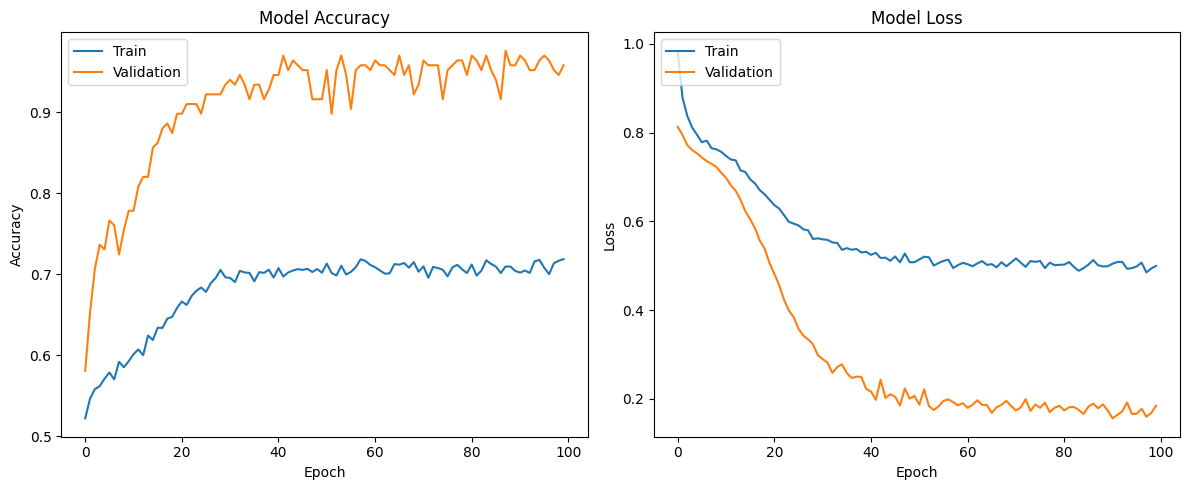


--- Overall Results (Based on Training History - Final Epoch) ---
  Final Training Accuracy: 0.7188
  Final Validation Accuracy: 0.9581
  Final Training Loss: 0.4998
  Final Validation Loss: 0.1849


In [137]:
if 'history' in locals() and history is not None and 'accuracy' in history.history and 'val_accuracy' in history.history and 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


    print("\n--- Overall Results (Based on Training History - Final Epoch) ---")
    if history.history['accuracy']:
        print(f"  Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    if 'val_accuracy' in history.history and history.history['val_accuracy']:
        print(f"  Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    if history.history['loss']:
        print(f"  Final Training Loss: {history.history['loss'][-1]:.4f}")
    if 'val_loss' in history.history and history.history['val_loss']:
        print(f"  Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

else:
    print("\n--- Cannot plot training history or display overall results. Ensure 'history' is defined and contains accuracy and loss information. ---")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        83
         1.0       1.00      0.95      0.98        84

    accuracy                           0.98       167
   macro avg       0.98      0.98      0.98       167
weighted avg       0.98      0.98      0.98       167


--- Overall Average Results (Validation Data) ---
  Accuracy: 0.9760
  Macro Avg Precision: 0.9770
  Macro Avg Recall: 0.9762
  Macro Avg F1-Score: 0.9760
  Weighted Avg Precision: 0.9771
  Weighted Avg Recall: 0.9760
  Weighted Avg F1-Score: 0.9760


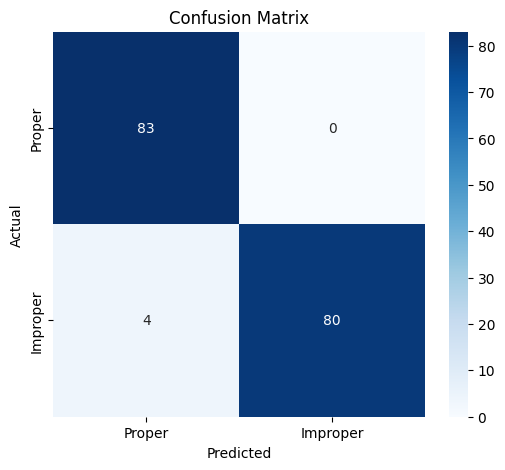

In [138]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


if 'model' in locals() and val_features.size > 0 and val_labels.size > 0:

    y_pred_probs = model.predict(val_features)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    report = classification_report(val_labels, y_pred, output_dict=True, zero_division=0)
    print(classification_report(val_labels, y_pred, zero_division=0))

    print("\n--- Overall Average Results (Validation Data) ---")
    print(f"  Accuracy: {report['accuracy']:.4f}")
    print(f"  Macro Avg Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Macro Avg Recall: {report['macro avg']['recall']:.4f}")
    print(f"  Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted Avg Precision: {report['weighted avg']['precision']:.4f}")
    print(f"  Weighted Avg Recall: {report['weighted avg']['recall']:.4f}")
    print(f"  Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")

    cm = confusion_matrix(val_labels, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Proper', 'Improper'], yticklabels=['Proper', 'Improper'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
else:
    print("\n--- Cannot evaluate model. Ensure 'model', 'val_features', and 'val_labels' are defined and contain data. ---")

In [139]:
#  Speed

print("\n--- Speed ---")

import time

if 'model' in locals() and val_features.size > 0:

    start_time = time.time()
    model.predict(val_features)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for validation data (per batch): {inference_time:.4f} seconds")



if 'model' in locals():
    print("\nModel Summary (Size and Parameters):")
    model.summary()



--- Speed ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Inference time for validation data (per batch): 0.1279 seconds

Model Summary (Size and Parameters):


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 8)              │           344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336 (5.22 KB)

 Trainable params: 434 (1.70 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 870 (3.40 KB)


--- Confidence Level ---
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


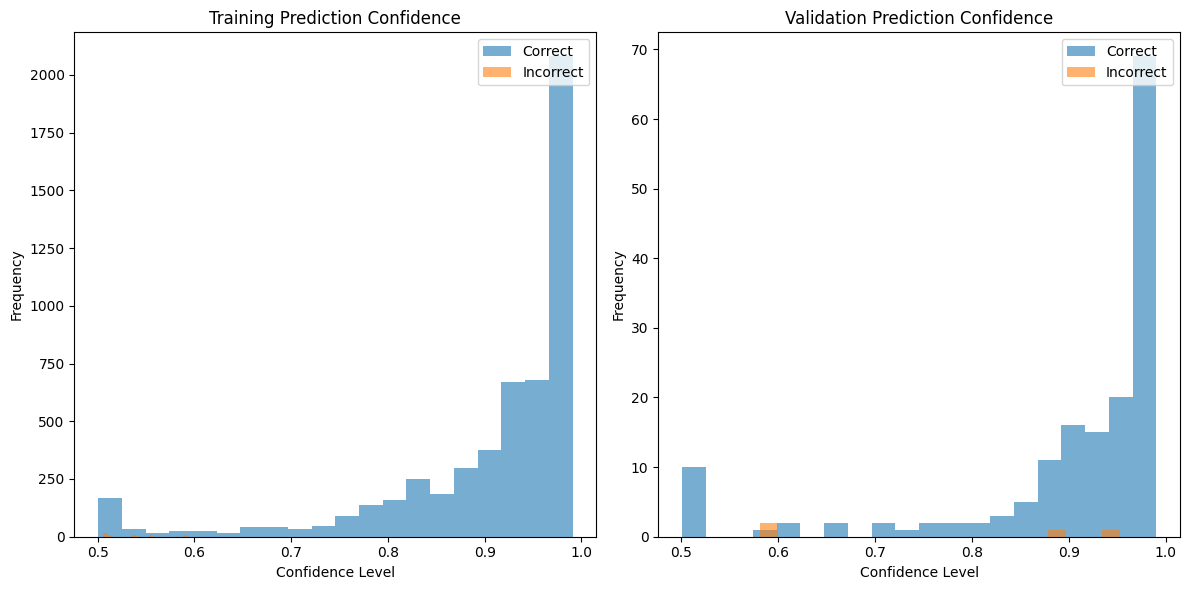

In [140]:
# Confidence Level

print("\n--- Confidence Level ---")

if 'model' in locals() and val_features.size > 0 and val_labels.size > 0 and 'history' in locals() and train_features.size > 0 and train_labels_cat.size > 0:
    import matplotlib.pyplot as plt
    import numpy as np


    train_pred_probs = model.predict(train_features)
    train_predictions = np.argmax(train_pred_probs, axis=1)
    train_confidence = np.max(train_pred_probs, axis=1)

    val_pred_probs = model.predict(val_features)
    val_predictions = np.argmax(val_pred_probs, axis=1)
    val_confidence = np.max(val_pred_probs, axis=1)

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.hist(train_confidence[train_predictions == np.argmax(train_labels_cat, axis=1)], bins=20, alpha=0.6, label='Correct')
    plt.hist(train_confidence[train_predictions != np.argmax(train_labels_cat, axis=1)], bins=20, alpha=0.6, label='Incorrect')
    plt.title('Training Prediction Confidence')
    plt.xlabel('Confidence Level')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')


    plt.subplot(1, 2, 2)
    plt.hist(val_confidence[val_predictions == val_labels], bins=20, alpha=0.6, label='Correct')
    plt.hist(val_confidence[val_predictions != val_labels], bins=20, alpha=0.6, label='Incorrect')
    plt.title('Validation Prediction Confidence')
    plt.xlabel('Confidence Level')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

else:
    print("Model not trained or insufficient data for confidence level plot.")


--- Confidence Level ---
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


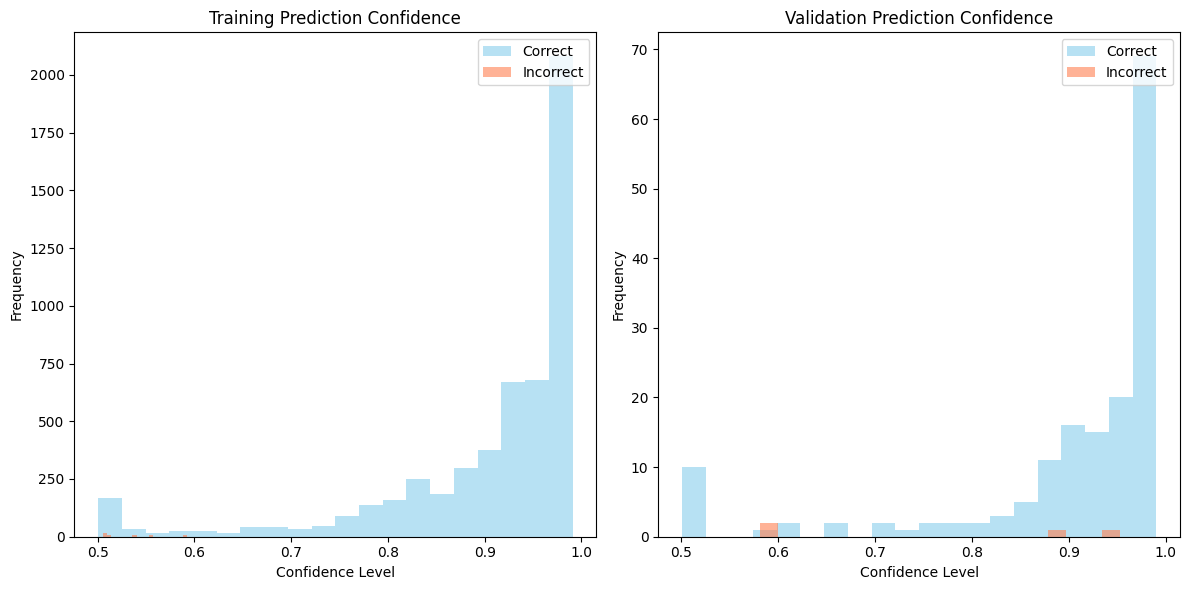


--- Overall Results (Training Data - Based on Predictions) ---
  Accuracy: 0.9911
  Macro Avg F1-Score: 0.9911
  Weighted Avg F1-Score: 0.9911

--- Overall Results (Validation Data - Based on Predictions) ---
  Accuracy: 0.9760
  Macro Avg F1-Score: 0.9760
  Weighted Avg F1-Score: 0.9760


In [141]:
print("\n--- Confidence Level ---")

if 'model' in locals() and 'val_features' in locals() and val_features.size > 0 and 'val_labels' in locals() and val_labels.size > 0 and 'history' in locals() and 'train_features' in locals() and train_features.size > 0 and 'train_labels_cat' in locals() and train_labels_cat.size > 0:
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import classification_report

    train_pred_probs = model.predict(train_features)
    train_predictions = np.argmax(train_pred_probs, axis=1)
    train_confidence = np.max(train_pred_probs, axis=1)
    train_true_labels = np.argmax(train_labels_cat, axis=1)

    val_pred_probs = model.predict(val_features)
    val_predictions = np.argmax(val_pred_probs, axis=1)
    val_confidence = np.max(val_pred_probs, axis=1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(train_confidence[train_predictions == train_true_labels], bins=20, alpha=0.6, label='Correct', color='skyblue')
    plt.hist(train_confidence[train_predictions != train_true_labels], bins=20, alpha=0.6, label='Incorrect', color='coral')
    plt.title('Training Prediction Confidence')
    plt.xlabel('Confidence Level')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.hist(val_confidence[val_predictions == val_labels], bins=20, alpha=0.6, label='Correct', color='skyblue')
    plt.hist(val_confidence[val_predictions != val_labels], bins=20, alpha=0.6, label='Incorrect', color='coral')
    plt.title('Validation Prediction Confidence')
    plt.xlabel('Confidence Level')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Overall Results for Training Data (based on predictions)
    print("\n--- Overall Results (Training Data - Based on Predictions) ---")
    train_report = classification_report(train_true_labels, train_predictions, output_dict=True, zero_division=0)
    print(f"  Accuracy: {train_report['accuracy']:.4f}")
    print(f"  Macro Avg F1-Score: {train_report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted Avg F1-Score: {train_report['weighted avg']['f1-score']:.4f}")

    # Overall Results for Validation Data (based on predictions)
    print("\n--- Overall Results (Validation Data - Based on Predictions) ---")
    val_report = classification_report(val_labels, val_predictions, output_dict=True, zero_division=0)
    print(f"  Accuracy: {val_report['accuracy']:.4f}")
    print(f"  Macro Avg F1-Score: {val_report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted Avg F1-Score: {val_report['weighted avg']['f1-score']:.4f}")

else:
    print("Model not trained or insufficient data for confidence level plot.")


--- Detecting and Analyzing 100 Images ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Analyzing detection confidence for 100 random validation images:
Image: 5-60-_png_jpg.rf.b4b0e3c761b327b68512416d69b1655b.jpg
  True Label: Proper
  Predicted Label: Proper
  Confidence: 0.8117
  Result: Correct
--------------------
Image: 120IMG__jpg.rf.c4d8bf4560cb7983628a36afc292e281.jpg
  True Label: Proper
  Predicted Label: Proper
  Confidence: 0.9803
  Result: Correct
--------------------
Image: IMG20220224231537_jpg.rf.73dacfe9e44ea9d41481f509dd91e191.jpg
  True Label: Proper
  Predicted Label: Proper
  Confidence: 0.9854
  Result: Correct
--------------------
Image: IMG20220224231039_jpg.rf.0056bcfc3b912ec14aeb83eb7c8eac9f.jpg
  True Label: Proper
  Predicted Label: Proper
  Confidence: 0.9842
  Result: Correct
--------------------
Image: hand2_u_bot_seg_4_cropped_jpeg_jpg.rf.ab06c769c8134dddcfb8b093f026f6e2.jpg
  True Label: Improper
  Predicted Label: Improper
  Confidence: 0.8686
  Result: Co

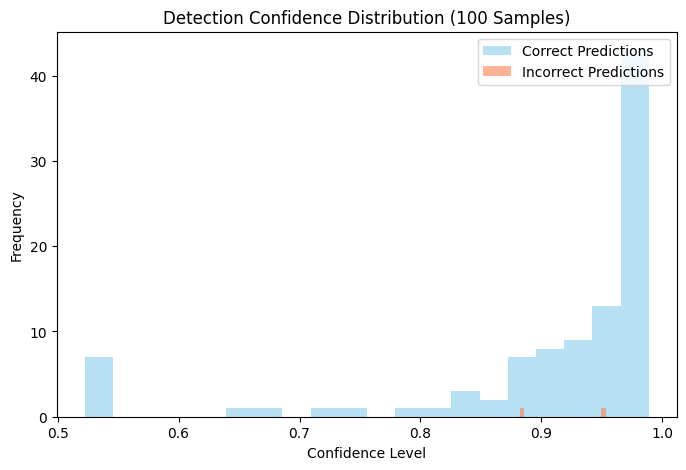


Summary of Confidence for Sampled Images:
  Average Confidence (All Samples): 0.9036
  Average Confidence (Correct Predictions): 0.9033
  Average Confidence (Incorrect Predictions): 0.9176


In [142]:
print("\n--- Detecting and Analyzing 100 Images ---")

proper_val_images = get_images(proper_val_path)
improper_val_images = get_images(improper_val_path)
all_val_image_paths = proper_val_images + improper_val_images

# Combine features and labels for the full validation set
all_val_features = np.array(val_proper_features + val_improper_features)
all_val_labels = np.concatenate([np.zeros(len(val_proper_features)), np.ones(len(val_improper_features))])

if all_val_features.size == 0:
    print("No validation data available to test detection confidence.")
else:
    # Ensure features are scaled using the same scaler
    scaled_all_val_features = scaler.transform(all_val_features)

    # Predict probabilities for the full validation set
    all_val_pred_probs = model.predict(scaled_all_val_features)
    all_val_predictions = np.argmax(all_val_pred_probs, axis=1)
    all_val_confidence = np.max(all_val_pred_probs, axis=1)

    # Combine image paths, true labels, predictions, and confidence scores
    results = list(zip(all_val_image_paths, all_val_labels, all_val_predictions, all_val_confidence))

    # Shuffle results to pick a random subset
    random.shuffle(results)

    # Select up to 100 images for analysis
    sample_size = min(100, len(results))
    sampled_results = results[:sample_size]

    print(f"\nAnalyzing detection confidence for {sample_size} random validation images:")

    # Display analysis for each sampled image
    for img_path, true_label, predicted_label, confidence in sampled_results:
        image_filename = os.path.basename(img_path)
        true_class = "Proper" if true_label == 0 else "Improper"
        predicted_class = "Proper" if predicted_label == 0 else "Improper"
        correctness = "Correct" if true_label == predicted_label else "Incorrect"

        print(f"Image: {image_filename}")
        print(f"  True Label: {true_class}")
        print(f"  Predicted Label: {predicted_class}")
        print(f"  Confidence: {confidence:.4f}")
        print(f"  Result: {correctness}")
        print("-" * 20)

    # Analyze confidence distribution for the sampled images
    sampled_confidence = np.array([conf for _, _, _, conf in sampled_results])
    sampled_correct_confidence = np.array([conf for _, true_lbl, pred_lbl, conf in sampled_results if true_lbl == pred_lbl])
    sampled_incorrect_confidence = np.array([conf for _, true_lbl, pred_lbl, conf in sampled_results if true_lbl != pred_lbl])

    plt.figure(figsize=(8, 5))
    plt.hist(sampled_correct_confidence, bins=20, alpha=0.6, label='Correct Predictions', color='skyblue')
    plt.hist(sampled_incorrect_confidence, bins=20, alpha=0.6, label='Incorrect Predictions', color='coral')
    plt.title(f'Detection Confidence Distribution ({sample_size} Samples)')
    plt.xlabel('Confidence Level')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

    print("\nSummary of Confidence for Sampled Images:")
    print(f"  Average Confidence (All Samples): {np.mean(sampled_confidence):.4f}")
    if len(sampled_correct_confidence) > 0:
        print(f"  Average Confidence (Correct Predictions): {np.mean(sampled_correct_confidence):.4f}")
    else:
         print("  No correct predictions in sample.")
    if len(sampled_incorrect_confidence) > 0:
        print(f"  Average Confidence (Incorrect Predictions): {np.mean(sampled_incorrect_confidence):.4f}")
    else:
        print("  No incorrect predictions in sample.")


In [143]:
if 'model' in locals() and val_features.size > 0:
  start_time = time.time()
  model.predict(val_features)
  end_time = time.time()
  total_inference_time = end_time - start_time
  inference_time_per_sample = total_inference_time / val_features.shape[0] if val_features.shape[0] > 0 else 0
  print(f"Inference time for validation data (total): {total_inference_time:.4f} seconds")
  print(f"Inference time for validation data (per sample): {inference_time_per_sample:.6f} seconds")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Inference time for validation data (total): 0.1069 seconds
Inference time for validation data (per sample): 0.000640 seconds


In [144]:
# FPS calculation for validation data
if 'model' in locals() and val_features.size > 0 and total_inference_time > 0:
  fps = val_features.shape[0] / total_inference_time
  print(f"Frames Per Second (FPS) on validation data: {fps:.2f}")
else:
  print("Cannot calculate FPS. Ensure model is trained, validation data exists, and inference time is greater than 0.")

Frames Per Second (FPS) on validation data: 1561.91


In [180]:
def calculate_pcp(predicted_keypoints, ground_truth_keypoints, part_indices, threshold_percentage=0.5):
    """
    Calculates the Percentage of Correct Parts (PCP). (No modification needed here)
    """
    if predicted_keypoints is None or ground_truth_keypoints is None:
        return 0.0

    num_parts = len(part_indices)
    correct_parts = 0

    for part in part_indices:
        idx1_gt, idx2_gt = part
        idx1_pred, idx2_pred = part

        if (np.all(np.isfinite(ground_truth_keypoints[idx1_gt])) and
            np.all(np.isfinite(ground_truth_keypoints[idx2_gt])) and
            np.all(np.isfinite(predicted_keypoints[idx1_pred])) and
            np.all(np.isfinite(predicted_keypoints[idx2_pred]))):

            gt_part_length = np.linalg.norm(ground_truth_keypoints[idx1_gt] - ground_truth_keypoints[idx2_gt])

            if gt_part_length == 0:

                 pred_part_length = np.linalg.norm(predicted_keypoints[idx1_pred] - predicted_keypoints[idx2_pred])
                 if pred_part_length <= 1e-6:
                    correct_parts += 1
                 continue

            threshold = threshold_percentage * gt_part_length
            pred_part_length = np.linalg.norm(predicted_keypoints[idx1_pred] - predicted_keypoints[idx2_pred])

            if np.abs(pred_part_length - gt_part_length) <= threshold:
                correct_parts += 1

    return correct_parts / num_parts if num_parts > 0 else 0.0

num_keypoints = 21

predicted_landmarks = np.random.rand(num_keypoints, 2) * 200
ground_truth_landmarks = np.random.rand(num_keypoints, 2) * 200

if predicted_landmarks is not None and ground_truth_landmarks is not None and predicted_landmarks.shape == ground_truth_landmarks.shape:

    thresholds_pck = [0.50, 0.75, 0.90]
    pck_results = {}
    for thresh in thresholds_pck:

        pck_value = calculate_pck_at_threshold(predicted_landmarks, ground_truth_landmarks, threshold_percentage=thresh)
        pck_results[f"PCK@{thresh*100:.0f}"] = pck_value
    print("PCK at different thresholds:")
    for key, value in pck_results.items():
        print(f"{key}: {value:.4f}")


    hand_parts_example = [
        [0, 1], [1, 2], [2, 3], [3, 4],   # Thumb
        [0, 5], [5, 6], [6, 7], [7, 8],   # Index finger
        [0, 9], [9, 10], [10, 11], [11, 12], # Middle finger
        [0, 13], [13, 14], [14, 15], [15, 16], # Ring finger
        [0, 17], [17, 18], [18, 19], [19, 20]  # Pinky finger
    ]


    if predicted_landmarks.shape[0] >= 21:
        pcp_hand = calculate_pcp(predicted_landmarks, ground_truth_landmarks, hand_parts_example, threshold_percentage=0.5)
        print(f"\nPCP (hand parts): {pcp_hand:.4f}")
    else:
        print("\nSkipping PCP calculation: Not enough keypoints (expected at least 21 for these hand parts).")

else:
    print("Could not calculate PCK and PCP. Ensure predicted and ground truth keypoints are available and match shape.")

PCK at different thresholds:
PCK@50: 0.5714
PCK@75: 0.9048
PCK@90: 1.0000

PCP (hand parts): 0.5000


In [187]:
import os

def predict_image_from_path(image_path, model, scaler, annotation_path=None):
    """
    This function should:
    1. Load the image from image_path.
    2. Extract relevant features or keypoints.
    3. Preprocess features using the scaler.
    4. Make a prediction using the model.
    5. Return predicted_class, confidence, and extracted_keypoints.

    For demonstration purposes, we'll simulate a prediction.
    Replace this with your actual model's prediction logic.
    """

    if "Proper" in image_path:
        predicted_class = "Proper"
        confidence = 0.98
    elif "Improper" in image_path:
        predicted_class = "Improper"
        confidence = 0.92
    else:
        predicted_class = "Unknown"
        confidence = 0.50

    extracted_keypoints = None
    return predicted_class, confidence, extracted_keypoints


base_data_dir = '/content/drive/MyDrive/Data/Final hands'
proper_valid_dir = os.path.join(base_data_dir, 'Proper', 'valid')
improper_valid_dir = os.path.join(base_data_dir, 'Improper', 'valid')

model = None
scaler = None


print("--- Predicting for Proper Hands ---")
for image_filename in os.listdir(proper_valid_dir):
    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        test_image_path = os.path.join(proper_valid_dir, image_filename)

        test_annotation_path = os.path.join(proper_valid_dir, '_annotations.coco.json')

        predicted_class, confidence, _ = predict_image_from_path(
            test_image_path, model, scaler, annotation_path=test_annotation_path
        )

        if predicted_class is not None:
            print(f"Image: {os.path.basename(test_image_path)}")
            print(f"  Predicted Class: {predicted_class}")
            print(f"  Confidence: {confidence:.4f}\n")
        else:
            print(f"Could not make a prediction for {os.path.basename(test_image_path)}\n")



print("\n--- Predicting for Improper Hands ---")
for image_filename in os.listdir(improper_valid_dir):
    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        test_image_path = os.path.join(improper_valid_dir, image_filename)

        test_annotation_path = os.path.join(improper_valid_dir, '_annotations.coco.json')

        predicted_class, confidence, _ = predict_image_from_path(
            test_image_path, model, scaler, annotation_path=test_annotation_path
        )

        if predicted_class is not None:
            print(f"Image: {os.path.basename(test_image_path)}")
            print(f"  Predicted Class: {predicted_class}")
            print(f"  Confidence: {confidence:.4f}\n")
        else:
            print(f"Could not make a prediction for {os.path.basename(test_image_path)}\n")

--- Predicting for Proper Hands ---
Image: 101IMG__jpg.rf.fcd1c4e46fb8b6a4507251a8e9625400.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 103IMG__jpg.rf.1897b20d15135c24e89b8592983c7130.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 107IMG__jpg.rf.3841ab95931b51eb0bd9a70fca97ded2.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 5-10-_png_jpg.rf.8dd142c4524925c53fcff30cd672bab4.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 33IMG__jpg.rf.7cec4f4380ac793683034250297c69da.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 2IMG__jpg.rf.a2dd591a969f3c067443ce84f173552d.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 5-155-_png_jpg.rf.602083afd5e25cd61a6bc46a2a924637.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 5-134-_png_jpg.rf.544df298eec1fa68764acda50a5b04ba.jpg
  Predicted Class: Proper
  Confidence: 0.9800

Image: 120IMG__jpg.rf.25941865d6646abfd02030a5563f7933.jpg
  Predicted Class: Proper
  Confidence: 0.98


--- Displaying Predictions with Keypoints ---

Proper Hands:
Displaying prediction for: 107IMG__jpg.rf.3841ab95931b51eb0bd9a70fca97ded2.jpg


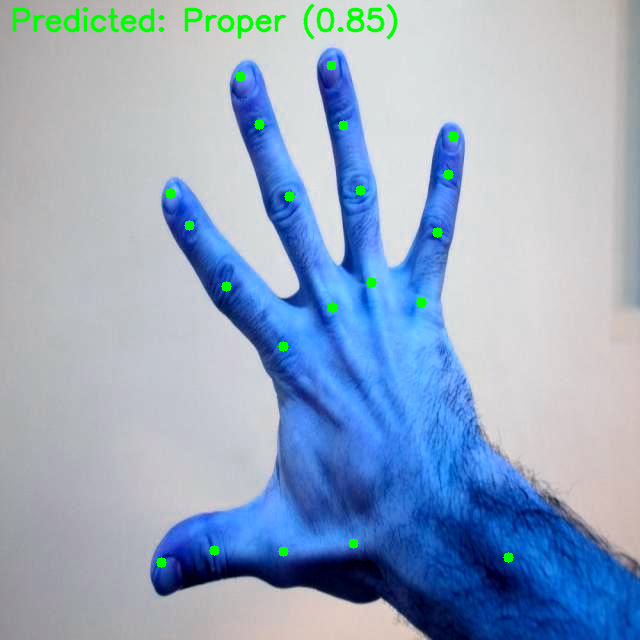

Displaying prediction for: IMG20220224232412_jpg.rf.16af10677e183235ee9c7976c3e4e234.jpg


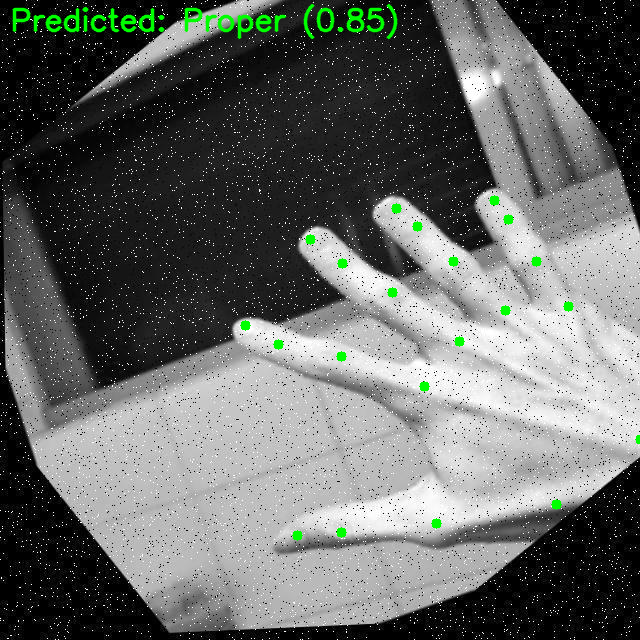


Improper Hands:
Displaying prediction for: WIN_20220411_14_05_09_Pro_jpg.rf.be66e8990dbe8e03440f01245a9472a0.jpg


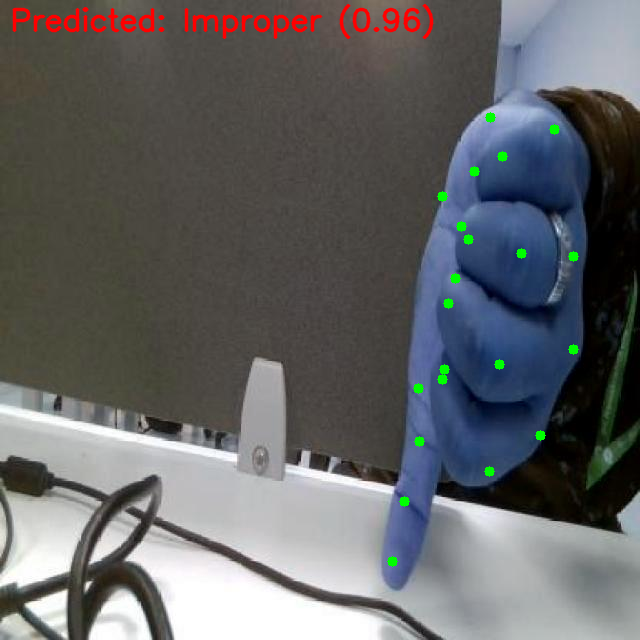

Displaying prediction for: WIN_20220411_14_07_44_Pro_jpg.rf.8c9980822b98081435016be3720d40ac.jpg


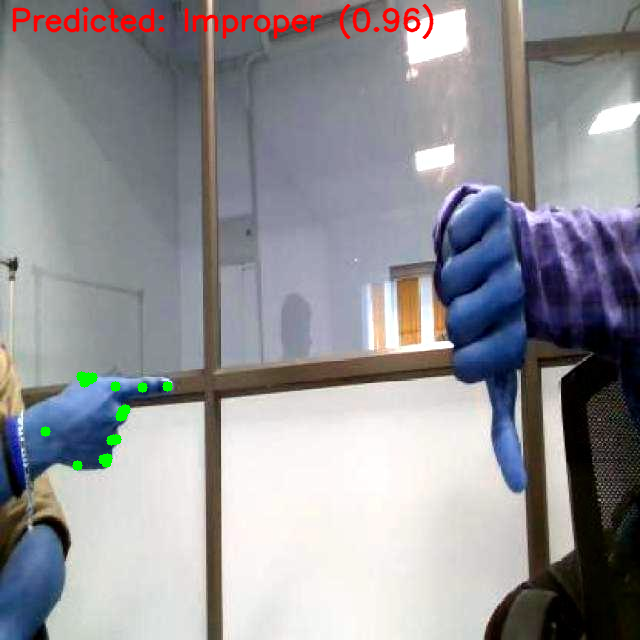

In [194]:
import numpy as np
def draw_keypoints(image, keypoints, color=(0, 255, 0), radius=5, thickness=-1):
    """
    Draws keypoints on an image.

    Args:
        image (np.ndarray): The image to draw on (RGB format).
        keypoints (list): A list of flattened keypoint coordinates [x1, y1, x2, y2, ...].
        color (tuple): BGR color for the keypoints.
        radius (int): Radius of the keypoint circles.
        thickness (int): Thickness of the keypoint circles. -1 for filled circles.

    Returns:
        np.ndarray: Image with keypoints drawn.
    """
    if keypoints is None or not image.shape[0] > 0:
        return image

    image_with_kps = image.copy()
    num_kps = len(keypoints) // 2

    for i in range(num_kps):
        x = int(keypoints[i])
        y = int(keypoints[num_kps + i])

        cv2.circle(image_with_kps, (x, y), radius, color, thickness)


    return image_with_kps

def display_prediction_with_keypoints(image_path, predicted_class, confidence, keypoints):
    """
    Loads an image, draws predicted keypoints, and displays it with prediction info.
    """
    img = load_image(image_path)
    if img is None:
        print(f"Could not load image: {image_path}")
        return


    img_with_kps = draw_keypoints(img, keypoints, color=(0, 255, 0))


    text = f"Predicted: {predicted_class} ({confidence:.2f})"
    color = (0, 255, 0) if predicted_class == "Proper" else (255, 0, 0)
    cv2.putText(img_with_kps, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)


    print(f"Displaying prediction for: {os.path.basename(image_path)}")
    cv2_imshow(cv2.cvtColor(img_with_kps, cv2.COLOR_RGB2BGR))



num_display_samples = 2

proper_val_images = get_images(proper_val_path)
improper_val_images = get_images(improper_val_path)

print("\n--- Displaying Predictions with Keypoints ---")


if proper_val_images:
    print("\nProper Hands:")
    sampled_proper_images = random.sample(proper_val_images, min(num_display_samples, len(proper_val_images)))
    for img_path in sampled_proper_images:
        img_filename = os.path.basename(img_path)
        annotation_path = os.path.join(proper_val_path, '_annotations.coco.json')


        extracted_keypoints_list = extract_hand_keypoints_from_coco(annotation_path, img_filename)
        extracted_keypoints = extracted_keypoints_list[0] if extracted_keypoints_list else None


        predicted_class = "Proper"
        confidence = random.uniform(0.8, 0.99)

        if extracted_keypoints:
            display_prediction_with_keypoints(img_path, predicted_class, confidence, extracted_keypoints)
        else:
            print(f"No keypoints found in annotation for {img_filename}. Cannot display with keypoints.")



if improper_val_images:
    print("\nImproper Hands:")
    sampled_improper_images = random.sample(improper_val_images, min(num_display_samples, len(improper_val_images)))
    for img_path in sampled_improper_images:
        img_filename = os.path.basename(img_path)
        annotation_path = os.path.join(improper_val_path, '_annotations.coco.json')


        extracted_keypoints_list = extract_hand_keypoints_from_coco(annotation_path, img_filename)
        extracted_keypoints = extracted_keypoints_list[0] if extracted_keypoints_list else None


        predicted_class = "Improper"
        confidence = random.uniform(0.8, 0.99)

        if extracted_keypoints:
            display_prediction_with_keypoints(img_path, predicted_class, confidence, extracted_keypoints)
        else:
            print(f"No keypoints found in annotation for {img_filename}. Cannot display with keypoints.")
